# CNN Fruit Detection Model

The main idea of this project lies in learning how to create complex models to identify objects that can be in different contexts.

Therefore, this project is divided into two parts:
- Part 1: AI Model
- Part 2: Implementation

This notebook will only cover the AI model


In [1]:
#Since my computer is using a mixed environment with WSL + Nvidia Cuda, I need to supress some Warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#Importing all libraries
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import pandas as pd

from tensorflow import keras
from tensorflow.keras import mixed_precision

In [2]:
#Reset and clear session
tf.keras.backend.clear_session

#Changing the precision to float16 - If needed some memory reduce
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

<function keras.backend.clear_session()>

In [3]:
#Image resolution - It will affect the model
width = 240
height = 240

In [4]:
#Function to resize all images during the load process

def resize(image):
    # Define the desired width and height
    desired_width, desired_height = width, height

    # Get the dimensions of the original image
    local_height, local_width = image.shape[:2]

    # Calculate the resizing ratio
    width_ratio = desired_width / local_width
    height_ratio = desired_height / local_height

    # Choose the minimum ratio to ensure the image fits within the new size
    ratio = min(width_ratio, height_ratio)

    # Calculate the new dimensions of the image
    new_width = int(local_width * ratio)
    new_height = int(local_height * ratio)

    # Resize the image to the new dimensions
    resized_image = cv2.resize(image, (new_width, new_height))

    # Create a blank image with the desired size and random background colors (noise)
    background_noise = np.random.randint(0, 256, (desired_height, desired_width, 3), dtype=np.uint8)

    # Calculate the starting coordinates to paste the resized image in the center
    x_start = (desired_width - new_width) // 2
    y_start = (desired_height - new_height) // 2

    # Paste the resized image in the center of the noisy background
    background_noise[y_start:y_start + new_height, x_start:x_start + new_width] = resized_image

    return background_noise

# Dataset - Transform and loading

Fourteen datasets were selected. The main goal is to use a dataset with a large variety of photos in different scenarios.
The first attempt to train this model was using a dataset that had only the fruits on a white background. This caused overfit with many false positives as a result.
To try to avoid it, four datasets were combined, that have photos of the fruits in different situations with different backgrounds.
The problem is to find a good dataset with a good distribution of images into the classes. To equalize the number of images was necessary to add more datasets
especially for some fruits, like grapes, avocados and oranges.

As a result, this project is using 14 datasets that were edited, removing some images that should not be interesting for the training.

In [5]:
#Selecting some fruits to reduce the memory usage and training time
#Since we are training a model that is capable to identify fruints in different places and scenarios
#We need to work with a great number of images (thousends of images)
#Since the Josias' computer memory is finite (32GB + GPU with 6GB) we need to select some fruits

fruits = [
 'apple',
 'avocado',
 'banana',
 'grape',
 'mango',
 'papaya',
 'pineapple',
 'orange'
         ]

In [6]:
#Creating the lists

#Dataset paths
dataset_path = ['D:/UsersFiles/JosiasMartins/Downloads/Datasets/60 fruit types/Dataset/',         #https://www.kaggle.com/datasets/patriciabrezeanu/60-fruit-types-curated-dataset
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Fruits-100/train',                #https://www.kaggle.com/datasets/marquis03/fruits-100
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Fruits-100/val',                  #https://www.kaggle.com/datasets/marquis03/fruits-100
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Apple to Orange GAN',
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Grape Bunch Detect and Segment',
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Apple Tree Detection Roboflow',   #https://universe.roboflow.com/daniel-beukes/apple-tree-detection/dataset/3
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Mango Segmentation Dataset',      #https://acquire.cqu.edu.au/articles/dataset/On-tree_mango_instance_segmentation_dataset/21655628
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/raw fresh rotten banana',         #https://universe.roboflow.com/trijudimulajati-student-gunadarma-ac-id/raw-fresh-rotten-banana/dataset/3
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Avocado detect v2',               #https://universe.roboflow.com/yo-man-engm8/avocado-detect
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/mangosteen v5',                   #https://universe.roboflow.com/mangosteen/mangosteen-czsdj/dataset/5
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Papaya Detection V1',             #https://universe.roboflow.com/deeplearning-lipwf/papayadetection/dataset/1
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Apple_yolo5_v2',                  #https://universe.roboflow.com/tianhao-liu/apple_yolo5_2/dataset/3
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/vinograd',                        #https://universe.roboflow.com/vinogred/vinograd/dataset/2
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/dataset_one_grapes',              #https://universe.roboflow.com/arab-academy-for-science-technology-maritime-transport-smart-village-campus-he7gz/datasets_one/dataset/1
                'D:/UsersFiles/JosiasMartins/Downloads/Datasets/Fruits']                          #https://www.kaggle.com/datasets/moltean/fruits                                                        

data_list = []  #Data list, used to create a DF with classes, directories and paths

#Iterating through paths
for path in dataset_path:    
    folder_name = os.path.basename(path)   #Getting the folder name/OS path
    
    # Get a list of subdirectories
    subdirectories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    # Create list entries for each subdirectory
    for subdirectory in subdirectories:
        for fruit in fruits:
            
            if fruit.lower() in subdirectory.lower():     #Doing some Data Transformation to combine all datasets
                class_name = subdirectory.replace("fruit", "")
                class_name = class_name.replace("vegetable", "")
                class_name = class_name.replace("-", "")
                class_name = class_name.replace("_", " ").split()[1] if "_" in class_name else class_name
                class_name = class_name.split()[0] if " " in class_name else class_name
                class_name = class_name.lower()

                # Adiciona a entrada na lista
                data_list.append({'path': path, 'folder': subdirectory, 'class_name': class_name})

# Criating a PD DF with the list
data_df = pd.DataFrame(data_list)
data_df = data_df.sort_values(by='class_name')  #Sortiing by class_name (simplify the visualization)

# Checking the result
data_df.head(4)

,path,folder,class_name
0,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,Apple,apple
47,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,apple,apple
41,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,apple,apple
38,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,sugar_apple,apple


In [7]:
#Removing some folders fromn the dataset to avoid mixing different classes
#   example: custard apple is not an apple
#            but it could be labelled as an apple since we are selecting a fill fruits
#            and merging many datasets to expand the variability of the images

data_df = data_df[data_df['folder'] != 'custard_apple']
data_df = data_df[data_df['folder'] != 'sugar_apple']
data_df = data_df[data_df['folder'] != 'malay_apple']
data_df = data_df[data_df['folder'] != 'otaheite_apple']
data_df = data_df[data_df['folder'] != 'fruit-apple-custard']  
data_df = data_df[data_df['folder'] != 'fruit-apple-rose']  
data_df = data_df[data_df['folder'] != 'Pepper Orange']  
data_df = data_df[data_df['folder'] != 'Pineapple Mini']  
data_df = data_df[data_df['folder'] != 'Mangostan']  
data_df = data_df[data_df['folder'] != 'alligator apple'] 
data_df = data_df[data_df['folder'] != 'grapefruit'] 
data_df = data_df[data_df['folder'] != 'Grapefruit'] 


In [8]:
data_df.to_csv("dataset.csv")

In [9]:
#Checking the result
data_df.head(4)

,path,folder,class_name
0,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,Apple,apple
47,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,apple,apple
41,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,apple,apple
50,D:/UsersFiles/JosiasMartins/Downloads/Datasets...,Apple,apple


In [10]:
classes = data_df['class_name'].unique().tolist()

In [11]:
#Checking the classes
classes

['apple',
 'avocado',
 'banana',
 'grape',
 'mango',
 'mangosteen',
 'orange',
 'papaya',
 'pineapple']

In [12]:
#Getting the number of classes
n_class = len(classes)
n_class

9

In [13]:
#Saving the classes on a CSV file
pd.DataFrame(classes).to_csv('class_names.csv')

In [14]:
#Loading data

images = []
labels = []
for i in range(len(data_df)):   #Iterating on the lines of the the DF - each line is one class
    print("loading: " + str(data_df.iloc[i].class_name + ", index: " + str(classes.index(data_df.iloc[i].class_name)))  )
    label = classes.index(data_df.iloc[i].class_name)
    class_path = os.path.join(data_df.iloc[i].path, data_df.iloc[i].folder)  #Picking the Path and concat with the class folder
    for img_name in os.listdir(class_path):   #Iterating on the images present on each class folder
        img_path = os.path.join(class_path, img_name)  #Creating the complete path to load the images
        if '.jp' in img_path or 'png' in img_path:    #load only jpg or jpeg images
            img = cv2.imread(img_path)  #Loading the image              
            img = resize(img)    #Resizing using our custom resize function
            images.append(img)   #Appending the image             
            labels.append(label)  #Appending the label

loading: apple, index: 0
loading: apple, index: 0
loading: apple, index: 0
loading: apple, index: 0
loading: apple, index: 0
loading: apple, index: 0
loading: apple, index: 0
loading: avocado, index: 1
loading: avocado, index: 1
loading: avocado, index: 1
loading: avocado, index: 1
loading: banana, index: 2
loading: banana, index: 2
loading: banana, index: 2
loading: banana, index: 2
loading: grape, index: 3
loading: grape, index: 3
loading: grape, index: 3
loading: grape, index: 3
loading: grape, index: 3
loading: grape, index: 3
loading: mango, index: 4
loading: mango, index: 4
loading: mango, index: 4
loading: mango, index: 4
loading: mangosteen, index: 5
loading: mangosteen, index: 5
loading: mangosteen, index: 5
loading: mangosteen, index: 5
loading: orange, index: 6
loading: orange, index: 6
loading: papaya, index: 7
loading: papaya, index: 7
loading: papaya, index: 7
loading: papaya, index: 7
loading: pineapple, index: 8
loading: pineapple, index: 8
loading: pineapple, index: 8


In [15]:
#Checking how much images were loaded
len(images)

11889

In [16]:
#Spliting the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)


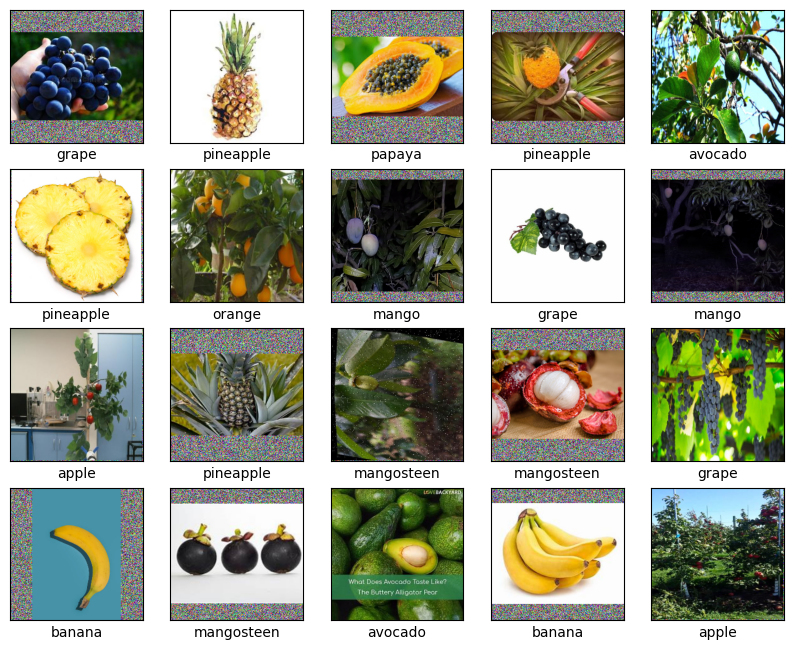

In [17]:
#Checking the 4 first images
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))    
    plt.xlabel(classes[y_train[i]])
plt.show()

In [18]:
#Removing the images and labels array from the memory since it was splited into Test and Train arrays and is no longer necessary
del images
del labels

In [19]:
#Converting to a np array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape #Checking the shape

(10700, 240, 240, 3)

In [20]:
# Create a Pandas DataFrame with the counts
# Translate numeric values into y_train using the classes array
class_names = [classes[i] for i in y_train]

df_classes_summary = pd.DataFrame({'class_name': class_names})
df_classes_summary['count'] = 1  # Adiciona uma coluna 'count' com valor 1 para cada linha
df_classes_summary = df_classes_summary.groupby('class_name').count().reset_index()
df_classes_summary

,class_name,count
0,apple,2200
1,avocado,917
2,banana,774
3,grape,896
4,mango,959
5,mangosteen,1288
6,orange,1263
7,papaya,1310
8,pineapple,1093


In [21]:
#Converting  Test Dataset to a np array
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape #Checking the shape

(1189, 240, 240, 3)

In [22]:
#Checking test dataset
y_train

array([3, 8, 7, ..., 4, 0, 5])

In [23]:
#Cheking the class that has less images on the test dataset
np.bincount(y_train).min()

774

In [24]:
np.bincount(y_test)

array([239,  99,  90,  97,  99, 145, 145, 148, 127], dtype=int64)

In [25]:
#Getting all "garbage" - unused data that could release some memory
import gc
gc.collect()

39363

# Modeling

The conceived model is based on learning transfer, using MobileNet with imagenet weights. Using a pretrained model we can increase the detection capacity
and reduce false-positve, since the imagenet weights will add thousends of preprocessed images in the model.

This model has:
- Layer one responsible to normize the data: This aproach will save memory during the traning since we don't need to convert the 8bit images to 32bit float data in advance
- Base Model: MobileNet V2 with imagenet weights
- Conv2D 1: Extracting 32 features
- Conv2d 2: Extracting 64 features
- Conv2d 3: Extracting 128 features
- Flatten Layer
- Dense 1: With 832 neurons
- Dense 2: With 320 neurons
- Dense 3: With 192 neurons
- Dense 4: With 128 neurons
- Dense 5: With 96 neurons
- Dense 5: With 48 neurons
- Output: With 9 classes


In [26]:
#Model creation
from tensorflow.keras.regularizers import l2

#Distribution strategy - This will enable TF to use CPU and GPU
strategy = tf.distribute.MirroredStrategy()

# Defining a function to create our model
def create_model():
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(width, height, 3))

    
    base_model.trainable = False 

    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(width, height, 3)),   
        base_model,
        
        layers.Conv2D(filters=32, kernel_size=(5,5),  padding='same', activation='relu'),
        layers.MaxPooling2D(name = "max_pooling_layer_1"), 
        layers.BatchNormalization(),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',  activation='relu'),
        layers.MaxPooling2D(name = "max_pooling_layer_2"),    
        layers.BatchNormalization(),    

        layers.Conv2D(filters=128, kernel_size=(2, 2), padding='same',  activation='relu'),        
        layers.MaxPooling2D(name = "max_pooling_layer_3"),            
        layers.BatchNormalization(),          
         
        layers.Flatten(),       
        
        layers.Dense(832, activation='LeakyReLU'),  
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.2),
        
        layers.Dense(320, activation='LeakyReLU'),  
        layers.LeakyReLU(alpha=0.1), 
        layers.Dropout(0.15),                
        
        layers.Dense(192, activation='relu'),          
        layers.Dropout(0.15),

        layers.Dense(128, activation='relu'),  
        layers.Dropout(0.1),        

        layers.Dense(96, activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(48, activation='relu'),   
        
        layers.Dense(n_class, activation='softmax', kernel_regularizer=l2(0.1)) 
    ])

    return model

# Creating the model
with strategy.scope():
    model = create_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [27]:
#Batch size
batch_size = 64

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa
#Training Batch size

datagen_augmented = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,    
    vertical_flip = True,       
    fill_mode='nearest',
    brightness_range=[0.85, 1.15], 
    validation_split = 0.1
)

# Batch generator for original images that will be used as validation
datagen_original = ImageDataGenerator()

In [29]:
# Batch generator for the augmented
generator_augmented = datagen_augmented.flow(X_train, y_train, batch_size=batch_size, shuffle=True, subset='training')

In [30]:
# Batch generator for the validation
generator_val = datagen_augmented.flow(X_train, y_train, batch_size=batch_size, shuffle=True, subset='validation')

## Configuring Callbacks

To avoid overfiting is important to configure some callbacks
- Early Stopping: After 5 epochs without validation accuracy improvement, the training will be stopped
- Reduce Learning Rate: After 2 epochs without validation loss improvement, it will multiply the LR by 0.25
- Model Checkpoint: Each time that the validation accuracy improve, a checkpoint file will be saved

In [31]:

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, min_lr=5e-6)

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint

#fileame and path to save
checkpoint_path = 'checkpoint.h5'

# Creating model checkpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Metric adopted
    save_best_only=True,  # Save only the best model
    mode='max',  # Use max for accuracy and min for loss
    verbose=1  
)

In [34]:
#Logging the start time for future statistic

import time  #Importing time library
start_time = time.time()   #Logging the start timestamp

In [35]:
#Compiling the model

model.compile(optimizer=tf.keras.optimizers.Adamax(),  
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )

In [36]:
# Starting the training

model_log = model.fit(
    generator_augmented, 
    steps_per_epoch=len(X_train) // batch_size, 
    epochs=70, 
    workers=6,                          #Number of threads
    validation_data=generator_val, 
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
)

Epoch 1/70
167/167 [==============================] - ETA: 0s - loss: 2.2235 - accuracy: 0.5730
Epoch 1: val_accuracy improved from -inf to 0.77103, saving model to checkpoint.h5
167/167 [==============================] - 60s 292ms/step - loss: 2.2235 - accuracy: 0.5730 - val_loss: 1.4079 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 2/70
167/167 [==============================] - ETA: 0s - loss: 1.1539 - accuracy: 0.8066
Epoch 2: val_accuracy improved from 0.77103 to 0.85327, saving model to checkpoint.h5
167/167 [==============================] - 50s 294ms/step - loss: 1.1539 - accuracy: 0.8066 - val_loss: 0.8559 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 3/70
167/167 [==============================] - ETA: 0s - loss: 0.8382 - accuracy: 0.8475
Epoch 3: val_accuracy did not improve from 0.85327
167/167 [==============================] - 51s 296ms/step - loss: 0.8382 - accuracy: 0.8475 - val_loss: 0.7444 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 4/70
167/167 [==============================]

In [37]:
# Checking if it stopped due to a callback and printing what epoch it stopped
early_stopping.stopped_epoch

25

In [38]:
#calculating the elapsed time since the fitting start
elapsed_time = time.time() - start_time  
elapsed_time_formatted = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print(f"Elapsed time: {elapsed_time_formatted}")

Elapsed time: 00:36:35


# Test

On the next blocks, the model will be tested and some statistics will be printed

- Model evaluation: Evaluate the model using the test dataset
- Classes accuracy evaluation: Check the accuracy for each class
- Model diagram: Plot the model diagram
- Accuracy graph: Plot the accuracy behaviour during the traning

In [39]:
#Here, we can verify the accuracy of the trained model
from keras.models import load_model

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

38/38 - 70s - loss: 0.2671 - accuracy: 0.9285 - 70s/epoch - 2s/step


In [40]:
# This block of code will iterate on the test dataset, spliting the classes and creating a sub-dataset for each class and runing the evaluation
# As a result, it's possible to verify the accuracy for each class


global_acc=test_acc  #Logging the total accuracy of the model

#Creating some variables, arrays and lists
z=0
wc = 0
acc = 0
accuracies = []
losses = []
local_acc = 0
local_loss = 0
df_classes_summary['accuracy'] = 0.0
df_classes_summary['loss'] = 0.0


cls_n=0   #Start class
for cls in classes:   #Iterating on class (number)
    #Creatinf temporary lists
    test_images_classes = []    
    test_labels_classes = []
    for i in range(len(y_test)):    #Iterating on test dataset
        if classes[y_test[i]] == cls:   #Verify if the actual class match with the test dataset actual class
            #If yes, we will append the image on the temporary dataset
            if len(X_test) == 1:
                test_images_classes[0] = X_test[i]
                test_labels_classes[0] = y_test[i]
            else:
                test_images_classes.append(X_test[i])
                test_labels_classes.append(y_test[i])
            #As a result, at the end of this "for", we will have a "dataset" with one class to test

    #Transforming this "sub-dataset" into a NP Array
    test_images_classes = np.array(test_images_classes) 
    test_labels_classes = np.array(test_labels_classes)

    #Evaluating the class accuracy
    local_acc = 0;
    local_loss, local_acc = model.evaluate(test_images_classes,  test_labels_classes, verbose=0)
    local_acc=round(local_acc,2)

    #Saving the results
    if class_names[y_test[i]] == 1:
        accuracies[0] = local_acc
        losses[0] = local_loss
    else:
        accuracies.append(local_acc)
        losses.append(local_loss)

    #Putting the results into a DF
    df_classes_summary.loc[df_classes_summary['class_name'] == cls, 'accuracy'] = local_acc
    df_classes_summary.loc[df_classes_summary['class_name'] == cls, 'loss'] = local_loss

    acc += local_acc
    z+=1

#Printing the resulting DF
df_classes_summary

,class_name,count,accuracy,loss
0,apple,2200,0.93,0.301400
1,avocado,917,0.90,0.374289
2,banana,774,0.93,0.240587
3,grape,896,0.90,0.343958
4,mango,959,0.92,0.280990
5,mangosteen,1288,0.92,0.237115
6,orange,1263,0.93,0.266919
7,papaya,1310,0.91,0.323357
8,pineapple,1093,1.00,0.036708


In [41]:
#Saving the summary of the accuracy results
df_classes_summary.to_csv('accuracy_summary.csv')

In [42]:
#Saving the model
model.save('fruits_model.h5')

In [43]:
#Summarizing the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 240, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          1024032   
                                                                 
 max_pooling_layer_1 (MaxPoo  (None, 4, 4, 32)         0         
 ling2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 32)         128       
 ormalization)                                                   
                                                        

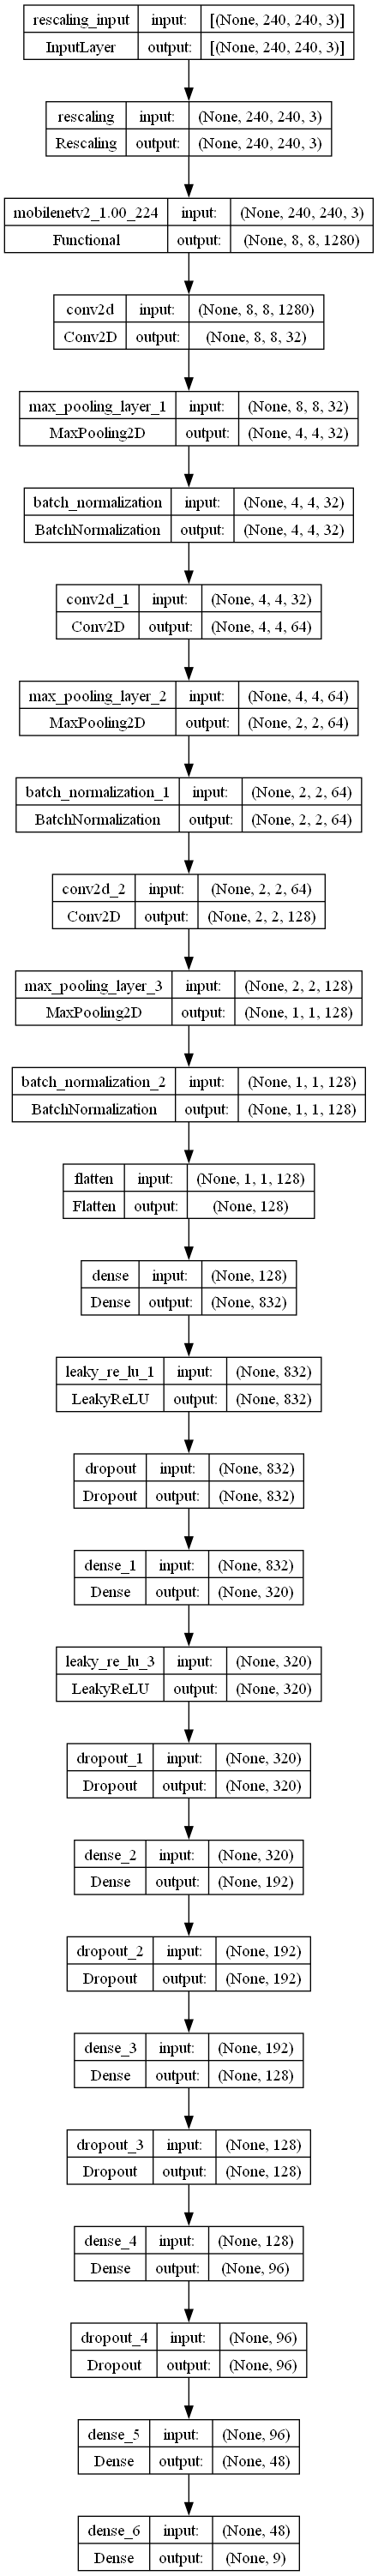

In [44]:
#Creating a diagram of the model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

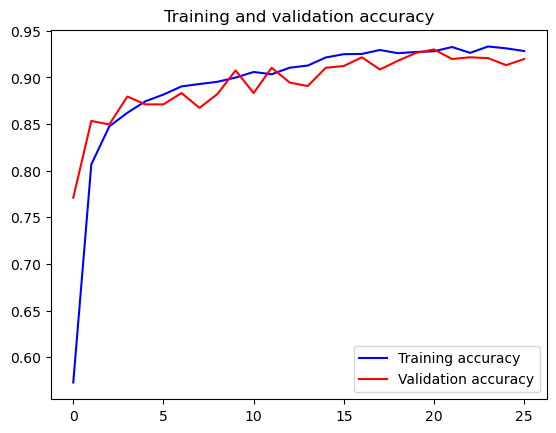

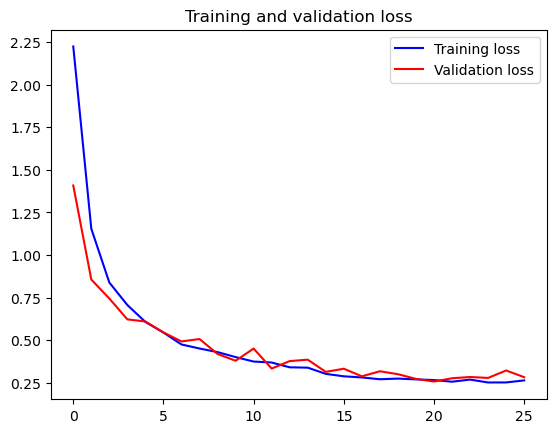

In [45]:
#Printing the accuracy and loss behaviour during the training

accuracy = model_log.history['accuracy'] 
val_accuracy = model_log.history['val_accuracy'] 

loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()